In [95]:
# Load libraries 
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from warnings import filterwarnings

In [173]:
# Set styling matplotlib
plt.style.use("ggplot")

In [110]:
# Set pandas interface
pd.set_option("display.max_rows", None)

In [96]:
# Set warnings levels
filterwarnings("ignore")

# Exploratory Data Analysis

In [4]:
# Read training set
data = pd.read_csv('dataset/train.csv')

In [5]:
# Overview dataset
data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


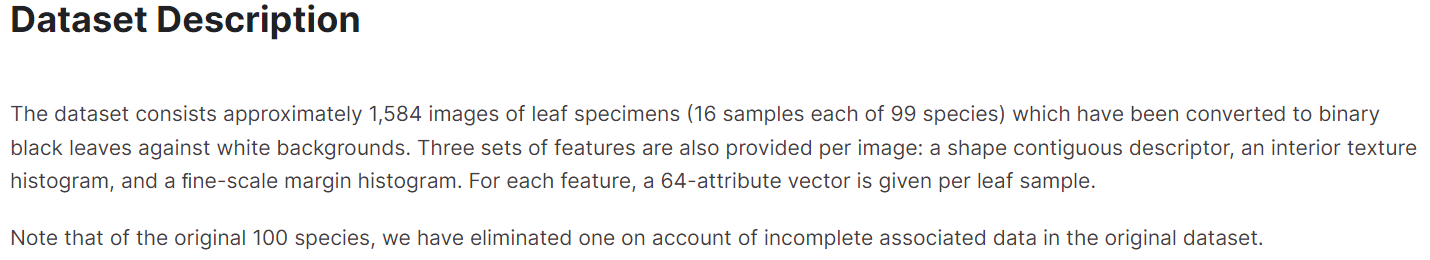

In [17]:
# Overview class distribution
data['species'].value_counts()

# NOTE: based on distribution below, we have around 99 classes with 10 sample of image, due SVM algorithm perform poorly
#       at large multiclass dataset, we reduce our dataset into 10 classes based on top 10 from Counter.

Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: species, Length: 99, dtype: int64

![](https://static.javatpoint.com/tutorial/machine-learning/images/support-vector-machine-algorithm.png)

In [20]:
# List top 10 species based on distribution counted
target_class = list(data['species'].value_counts()[:10].keys())
target_class

['Acer_Opalus',
 'Crataegus_Monogyna',
 'Acer_Mono',
 'Magnolia_Heptapeta',
 'Acer_Capillipes',
 'Populus_Nigra',
 'Alnus_Cordata',
 'Tilia_Platyphyllos',
 'Eucalyptus_Neglecta',
 'Quercus_Chrysolepis']

In [26]:
# Reduce dataset based on species indicated value from target_class
data = data[data['species'].isin(target_class)].reset_index(drop = True)

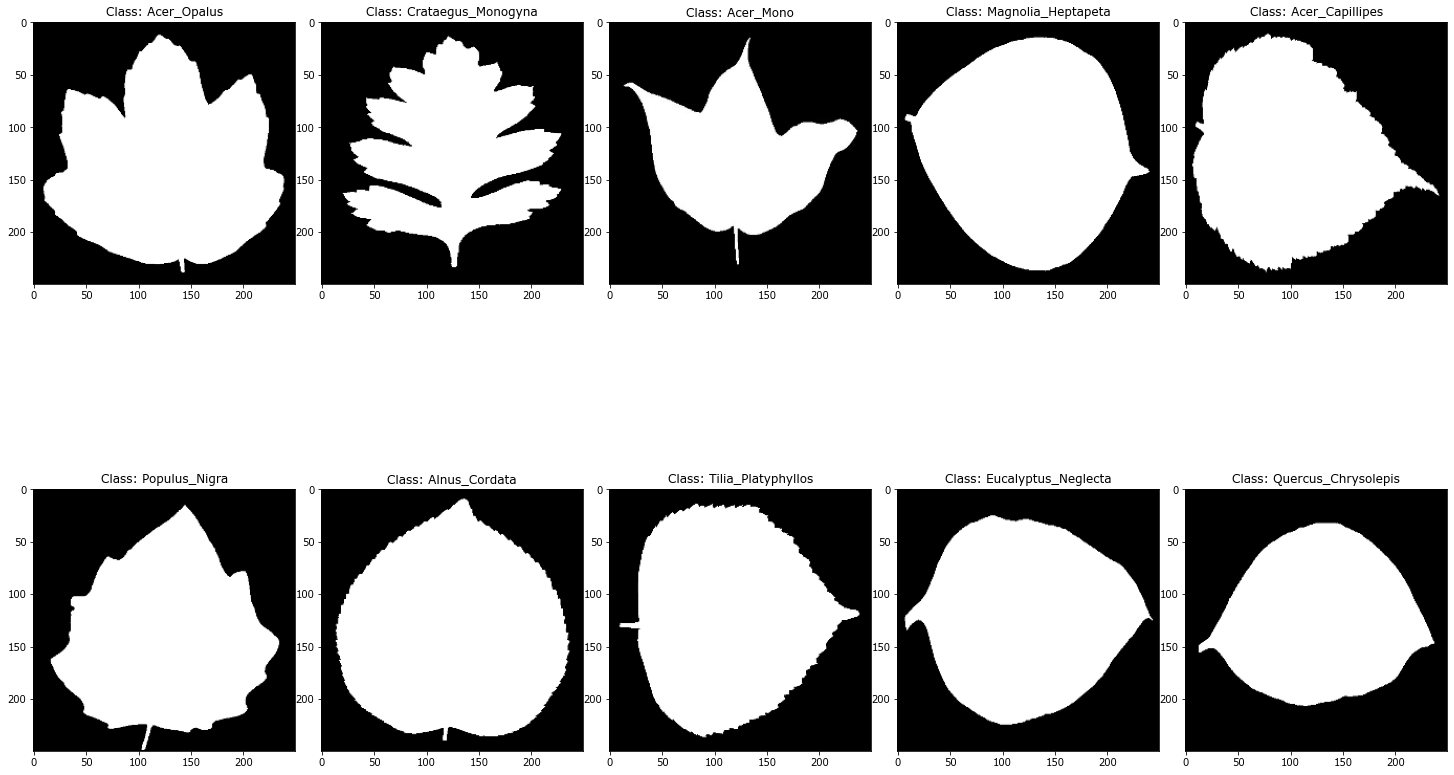

In [43]:
# Overview sample image on each class as figure
row, col = 2, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_row in range(row):
    for n_col in range(col):
        classes = target_class[count]
        filename = str(data[data['species'] == classes]['id'].iloc[0]) + '.jpg'
        image = cv.imread(os.path.join("dataset", "images", filename))[:, :, ::-1]
        image = cv.resize(image, (250, 250))
        ax[n_row, n_col].imshow(image)
        ax[n_row, n_col].set_title(f"Class: {classes}")
        count += 1
        
plt.tight_layout(pad=0);

In [48]:
# Overview label distribution
label_dist = pd.DataFrame(data['species'].value_counts()).reset_index()
label_dist.columns = ['species', 'count']
label_dist

# NOTE: distribution of each label is equal a.k.a balance, so we dont need to apply augmentation technique.

,species,count
0,Acer_Opalus,10
1,Quercus_Chrysolepis,10
2,Eucalyptus_Neglecta,10
3,Tilia_Platyphyllos,10
4,Alnus_Cordata,10
5,Populus_Nigra,10
6,Acer_Capillipes,10
7,Magnolia_Heptapeta,10
8,Acer_Mono,10
9,Crataegus_Monogyna,10


In [52]:
# Define feature, label, and metadata of dataset 
features = data.drop(labels = ['id', 'species'], axis = 1)
labels   = data['species']
metadata = list(map(lambda x: os.path.join("dataset", "image", str(x)) + ".jpg", data['id']))

# Data Preprocessing

In [116]:
# Load libraries
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

![](https://miro.medium.com/v2/resize:fit:532/format:webp/1*S8rfFkmLhDbOz4RGNwuz6g.png)

In [70]:
# Perform feature selection using chi square
chi_square_score = chi2(features, labels)
chi_square_score = list(chi_square_score[1])

In [90]:
# Get the highest feature of each group column [margin, shape, texture] (separate per 64 index)
prev_index = 0
cols = ['margin ', 'shape  ', 'texture']
for i, index in enumerate(range(64, 64 * 4, 64)):
    reduce_chi_square = chi_square_score[prev_index:index]
    highest_score = max(reduce_chi_square)
    index_feature = reduce_chi_square.index(highest_score)
    print(f"Feature : {cols[i]}\nColumn  : {features.columns[prev_index + index_feature]}\nScore   : {highest_score}\n")
    prev_index = index

Feature : margin 
Column  : margin34
Score   : 0.999999992262959

Feature : shape  
Column  : shape25
Score   : 0.9999999999997302

Feature : texture
Column  : texture61
Score   : 0.9999999993515383



In [102]:
# Define function to prevent repetitive code on distribution visualisation
def viz_dist_plot(column: str) -> px.histogram:    
    fig = px.histogram(
        features, x = column, 
        marginal = "box", hover_data = features.columns
    )
    fig.update_layout(
        title_text = f"Distribution Plot on {column}",
        title_x = 0.5
    )
    fig.show()

In [103]:
viz_dist_plot("margin34")

In [104]:
viz_dist_plot("shape25")

In [105]:
viz_dist_plot("texture61")

In [109]:
# Transform string label into numerical using Label Encoder method
encoder = LabelEncoder()
labels_encoder = encoder.fit_transform(labels)

In [115]:
# Overview label transformation result
pd.DataFrame({
    "Label Original": labels, 
    "Label Encoded" : labels_encoder
}).drop_duplicates()

,Label Original,Label Encoded
0,Acer_Opalus,2
1,Quercus_Chrysolepis,8
2,Eucalyptus_Neglecta,5
3,Tilia_Platyphyllos,9
4,Alnus_Cordata,3
5,Populus_Nigra,7
7,Acer_Capillipes,0
8,Magnolia_Heptapeta,6
9,Acer_Mono,1
10,Crataegus_Monogyna,4


![](https://d33wubrfki0l68.cloudfront.net/c39b2d19183ed14141a8b7b03943442d40efee0d/81e2a/wp-content/uploads/2019/03/train_test_split.png)

In [117]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoder, test_size = 0.2, random_state = 1)

## Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 192), (20, 192), (80,), (20,))

# Data Modeling

In [ ]:
# !pip install pretty-confusion-matrix

In [126]:
from sklearn.svm import SVC
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import classification_report, confusion_matrix

## Baseline Algorithm

In [120]:
# Define algorithm
model_svm_baseline = SVC()
model_svm_baseline.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [121]:
# Training Algorithm
model_svm_baseline.fit(X_train, y_train)

SVC()

In [123]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_train)
print(classification_report(y_train, pred, target_names = target_class))

                     precision    recall  f1-score   support

        Acer_Opalus       1.00      1.00      1.00         8
 Crataegus_Monogyna       1.00      1.00      1.00         9
          Acer_Mono       1.00      1.00      1.00         7
 Magnolia_Heptapeta       1.00      1.00      1.00         7
    Acer_Capillipes       1.00      1.00      1.00         7
      Populus_Nigra       1.00      1.00      1.00         8
      Alnus_Cordata       1.00      1.00      1.00         9
 Tilia_Platyphyllos       1.00      1.00      1.00         8
Eucalyptus_Neglecta       1.00      1.00      1.00         9
Quercus_Chrysolepis       1.00      1.00      1.00         8

           accuracy                           1.00        80
          macro avg       1.00      1.00      1.00        80
       weighted avg       1.00      1.00      1.00        80



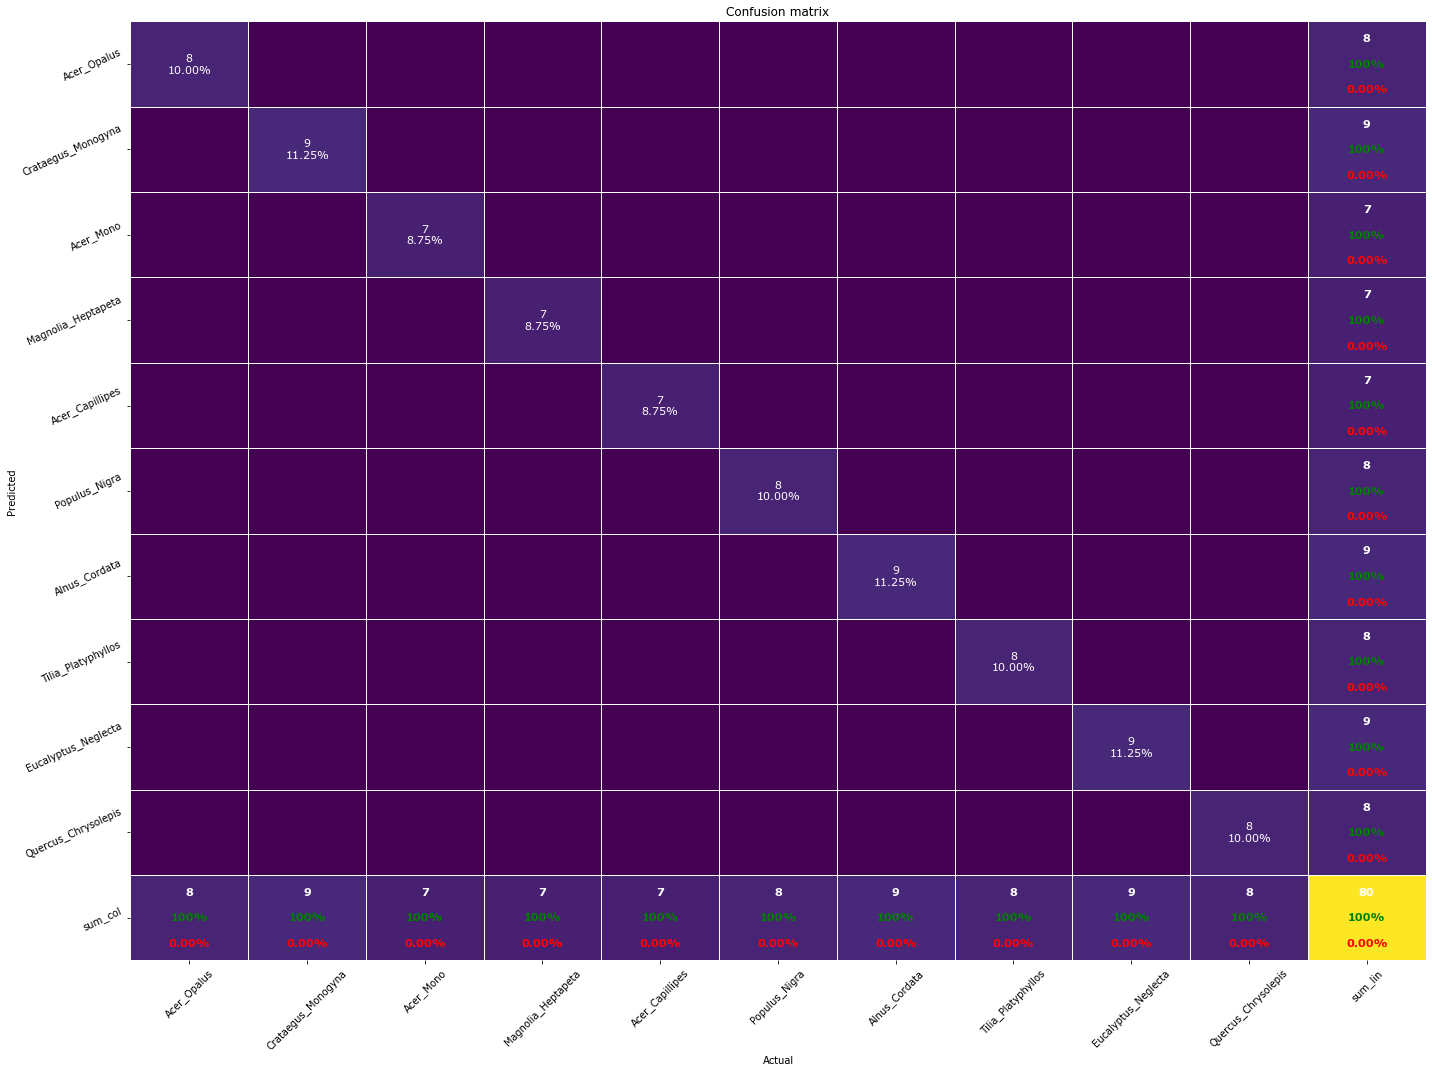

In [142]:
# Test on Training Set - confusion_matrix
array = confusion_matrix(y_train, pred)
array_df = pd.DataFrame(array, index = target_class, columns = target_class)
pp_matrix(array_df, cmap = "viridis", figsize = (20, 15))

In [143]:
# Test on Testing Set - classication_report
pred = model_svm_baseline.predict(X_test)
print(classification_report(y_test, pred, target_names = target_class))

                     precision    recall  f1-score   support

        Acer_Opalus       0.67      1.00      0.80         2
 Crataegus_Monogyna       1.00      1.00      1.00         1
          Acer_Mono       1.00      1.00      1.00         3
 Magnolia_Heptapeta       1.00      0.67      0.80         3
    Acer_Capillipes       1.00      1.00      1.00         3
      Populus_Nigra       1.00      1.00      1.00         2
      Alnus_Cordata       1.00      1.00      1.00         1
 Tilia_Platyphyllos       1.00      1.00      1.00         2
Eucalyptus_Neglecta       1.00      1.00      1.00         1
Quercus_Chrysolepis       1.00      1.00      1.00         2

           accuracy                           0.95        20
          macro avg       0.97      0.97      0.96        20
       weighted avg       0.97      0.95      0.95        20



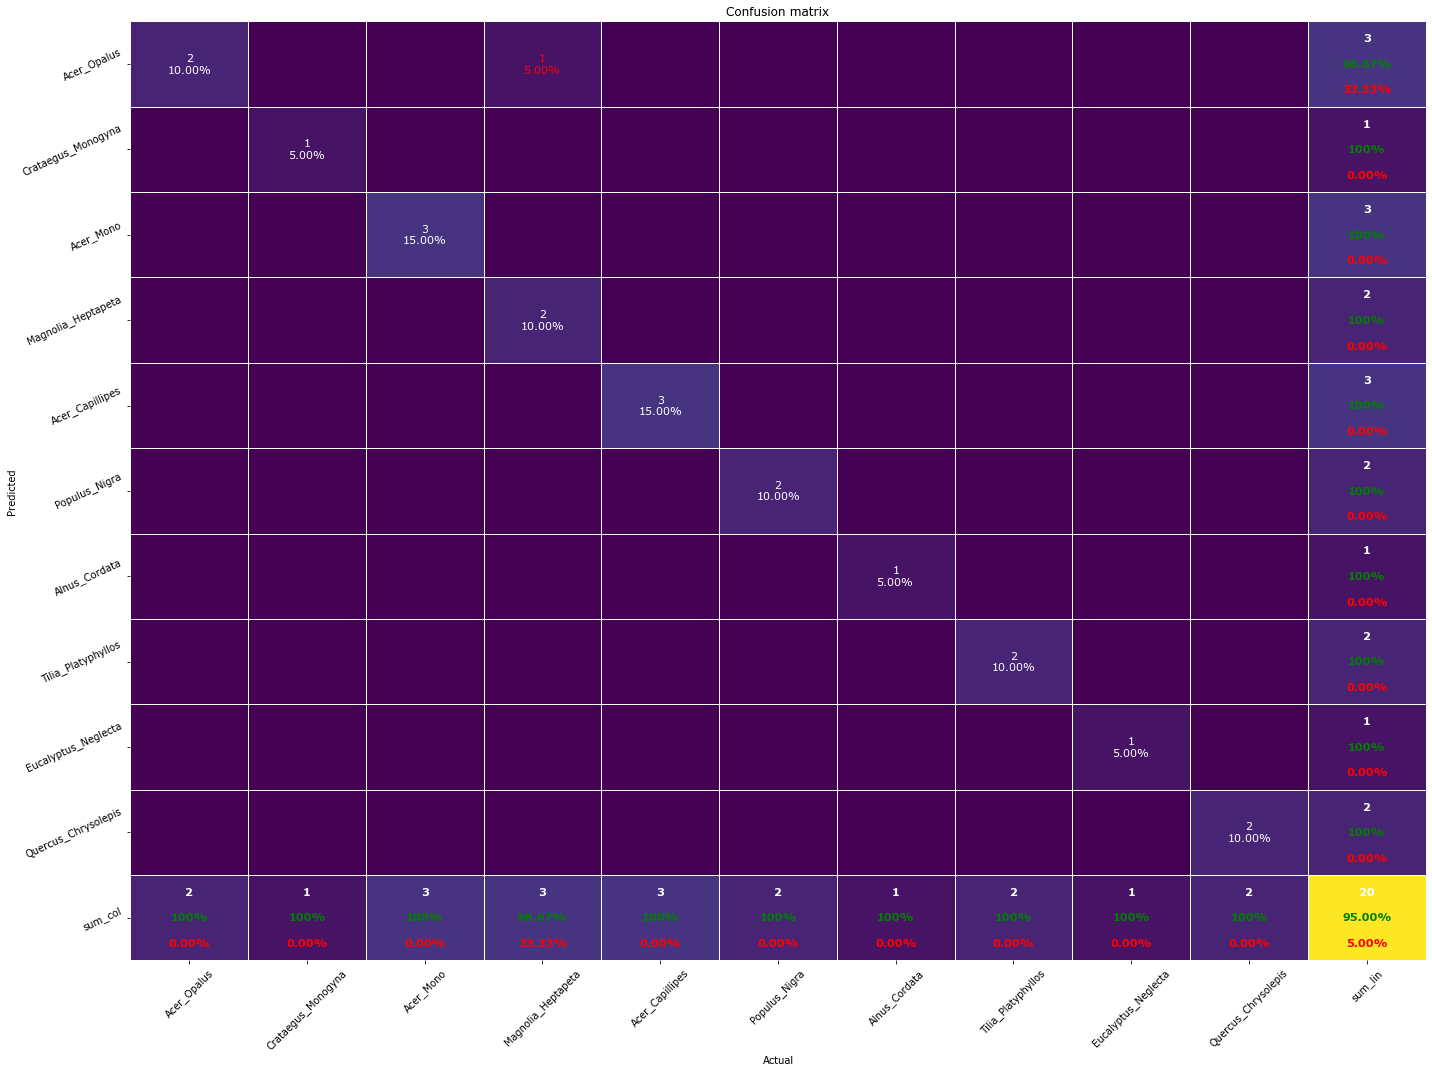

In [144]:
# Test on Testing Set - confusion_matrix
array = confusion_matrix(y_test, pred)
array_df = pd.DataFrame(array, index = target_class, columns = target_class)
pp_matrix(array_df, cmap = "viridis", figsize = (20, 15))

## Tuning Algorithm

![](https://journals.plos.org/plosone/article/figure/image?size=medium&id=10.1371/journal.pone.0235885.t001)

In [145]:
# Define list kernel
list_kernels = ["linear", "poly", "rbf", "sigmoid"]

In [146]:
# Define blank list to store metrics value
list_acc, list_pre, list_re, list_f1 = [], [], [], []

In [157]:
# Iter each kernel and apply on SVM algorithm
for kernel in list_kernels:
    svm_tuning = SVC(kernel=kernel)
    svm_tuning.fit(X_train, y_train)
    preds = svm_tuning.predict(X_test)
    metrics = classification_report(y_test, preds, output_dict = True)
    list_acc.append(metrics['accuracy'])
    list_pre.append(metrics['weighted avg']['precision'])
    list_re.append(metrics['weighted avg']['recall'])
    list_f1.append(metrics['weighted avg']['f1-score'])

In [174]:
# Wrap as dataframe metrics
metrics_final = pd.DataFrame({
    "SVM Kernels" : list_kernels, 
    "Accuracy"    : list_acc, 
    "Precision"   : list_pre, 
    "Recall"      : list_re, 
    "F1-Score"    : list_f1
})

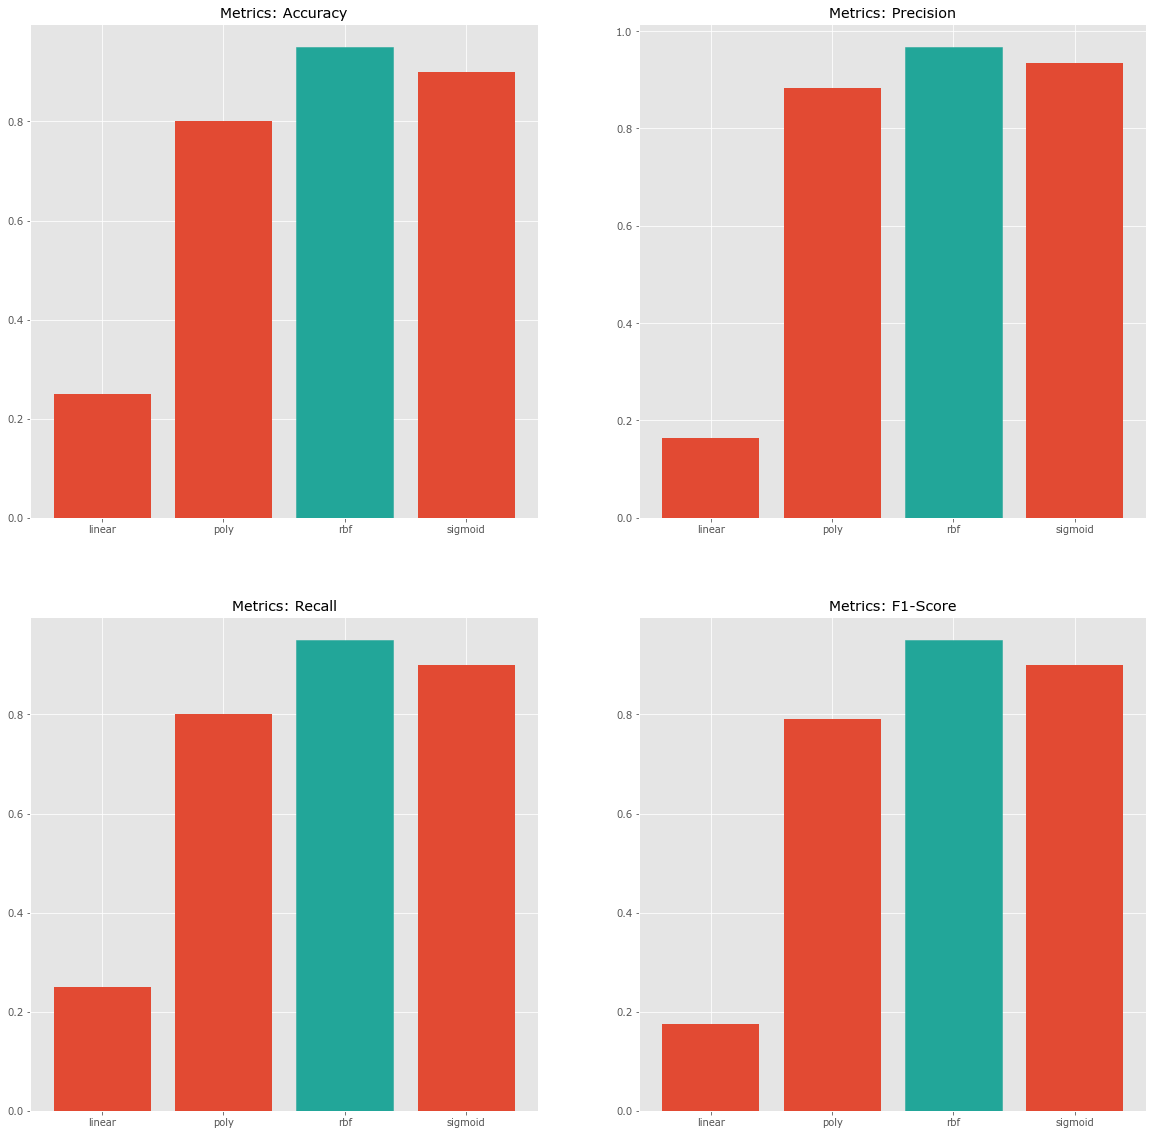

In [179]:
# Visualize metrics comparison
n_rows, n_cols = 2, 2
count = 0
fig, ax = plt.subplots(n_rows, n_cols, figsize = (20, 20))
list_metrics = metrics_final.columns[1:]

for row in range(n_rows):
    for col in range(n_cols):
        bar = ax[row, col].bar(x = list(range(1, 5)), height = metrics_final[list_metrics[count]])
        ax[row, col].set_xticks(list(range(1, 5)), list_kernels)
        ax[row, col].set_title(f"Metrics: {list_metrics[count]}")
        bar[2].set_color("#22A699")
        count += 1

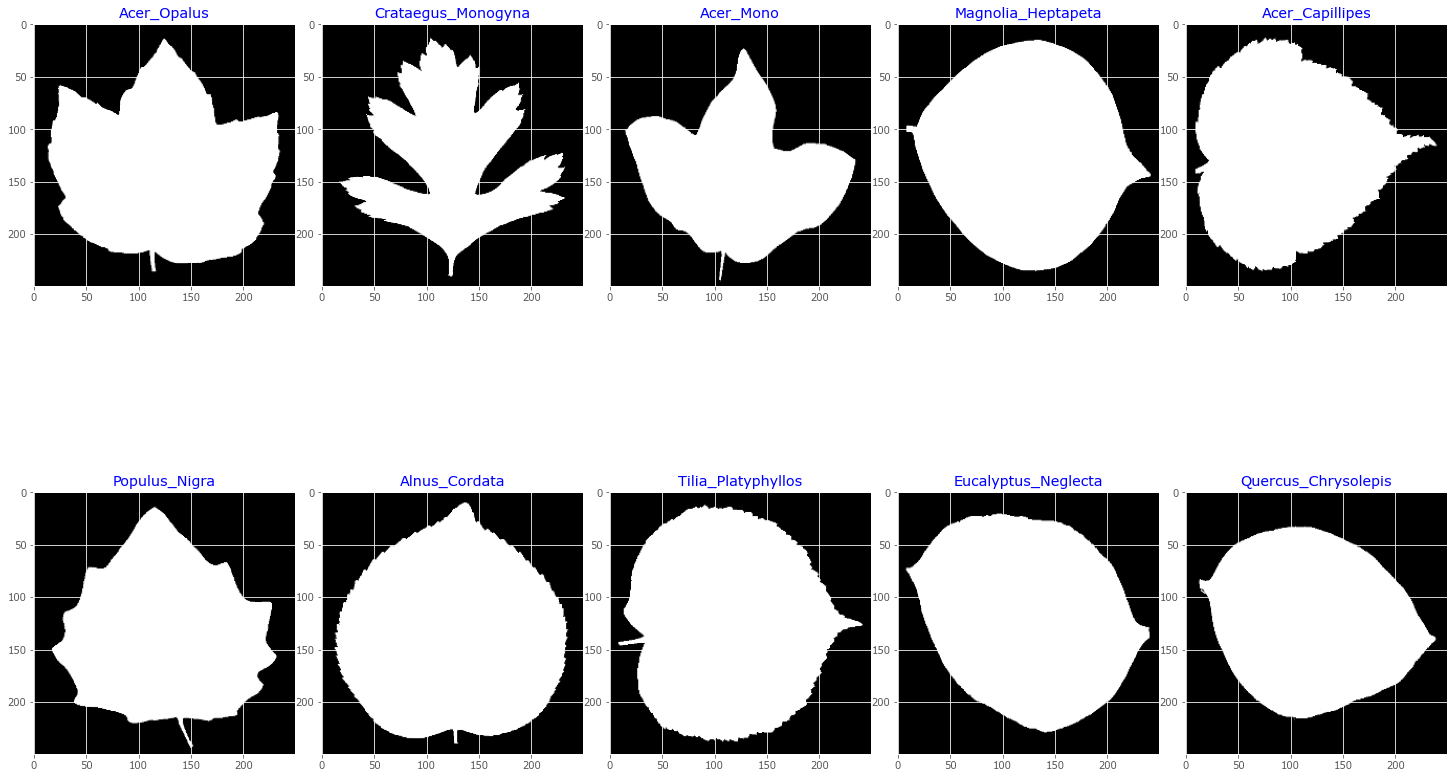

In [192]:
# Overview sample image on each class as figure
row, col = 2, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_row in range(row):
    for n_col in range(col):
        classes = target_class[count]
        
        n_feature = data[data['species'] == classes].iloc[-1, 2:]
        preds_encoder = model_svm_baseline.predict([n_feature])
        preds_label   = encoder.inverse_transform(preds_encoder)[0]
        
        filename = str(data[data['species'] == classes]['id'].iloc[-1]) + '.jpg'
        image = cv.imread(os.path.join("dataset", "images", filename))[:, :, ::-1]
        image = cv.resize(image, (250, 250))
        ax[n_row, n_col].imshow(image)
        ax[n_row, n_col].set_title(f"{preds_label}")
        ax[n_row, n_col].title.set_color("blue" if preds_label == classes else "red")
        count += 1
        
plt.tight_layout(pad=0);
# NOTE: Blue color indicate "correct" prediction